# desviación teórica RMS vs num samples

**Estudio del error cometido en la medición de potencia activa mediande sampling de un sensor SCT-030 030 y un conversor AD MCP 3008 montado en una Raspberry Pi 3 (Hat Rpi.gpio analog).**

* Se toman medidas de 4 canales (de 8) en cada ciclo; sin espera entre mediciones, se alcanza una velocidad de ~8ms por ciclo, pero la CPU de la RPI permanece al 100% y llega a provocar pequeños *freezes*. La temperatura de la RPI pasa de **85 ºC** (en un ambiente de casi 30ºC y baja humedad), por lo que supone un problema.

* Se experimenta con distintas frecuencias de sampling, además de utilizar una *rolling mean* para suavizar las mediciones. Finalmente, se establece un muestreo de **12 ms**, con una ventana de **2 segundos**.

En este *notebook* se analizan los datos adquiridos, y se simula la desviación y error del método para distintas estrategias de medida.


## Estudio de los datos adquiridos

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from datacharm import *
from datacharm.datafuncs import timeit
from enerpi.api import enerpi_data_catalog, enerpi_log
import random


cat = enerpi_data_catalog()
enerpidata = cat.get_all_data(with_summary_data=False)
print_info(enerpidata.describe())
enerpidata.tail()

***TIMEIT get_all_data TOOK: 0.907 s
              power         noise           ref           ldr
count  1.874958e+06  1.874958e+06  1.874958e+06  1.874958e+06
mean   3.237982e+02  7.591454e-03  8.214065e+01  2.661204e+02
std    2.846400e+02  5.681505e-04  4.406408e+00  2.426892e+02
min    1.124641e+02  3.420802e-03  1.000000e+00  1.100000e+01
25%    2.207630e+02  7.379435e-03  8.300000e+01  3.300000e+01
50%    2.505402e+02  7.588668e-03  8.400000e+01  1.940000e+02
75%    3.507848e+02  7.729332e-03  8.400000e+01  5.050000e+02
max    5.304222e+03  7.956649e-02  8.400000e+01  7.480000e+02


,power,noise,ref,ldr,high_delta,execution
ts,,,,,,
2016-09-04 15:25:13.221273,613.301880,0.007019,83,697,False,False
2016-09-04 15:25:14.221866,616.418945,0.007131,82,698,False,False
2016-09-04 15:25:15.227823,634.593384,0.007264,83,697,False,False
2016-09-04 15:25:16.237708,645.055176,0.007218,83,690,False,False
2016-09-04 15:25:17.245148,649.788696,0.007235,83,672,False,False


count    1.874958e+06
mean     8.214065e+01
std      4.406408e+00
min      1.000000e+00
25%      8.300000e+01
50%      8.400000e+01
75%      8.400000e+01
max      8.400000e+01
Name: ref, dtype: float64


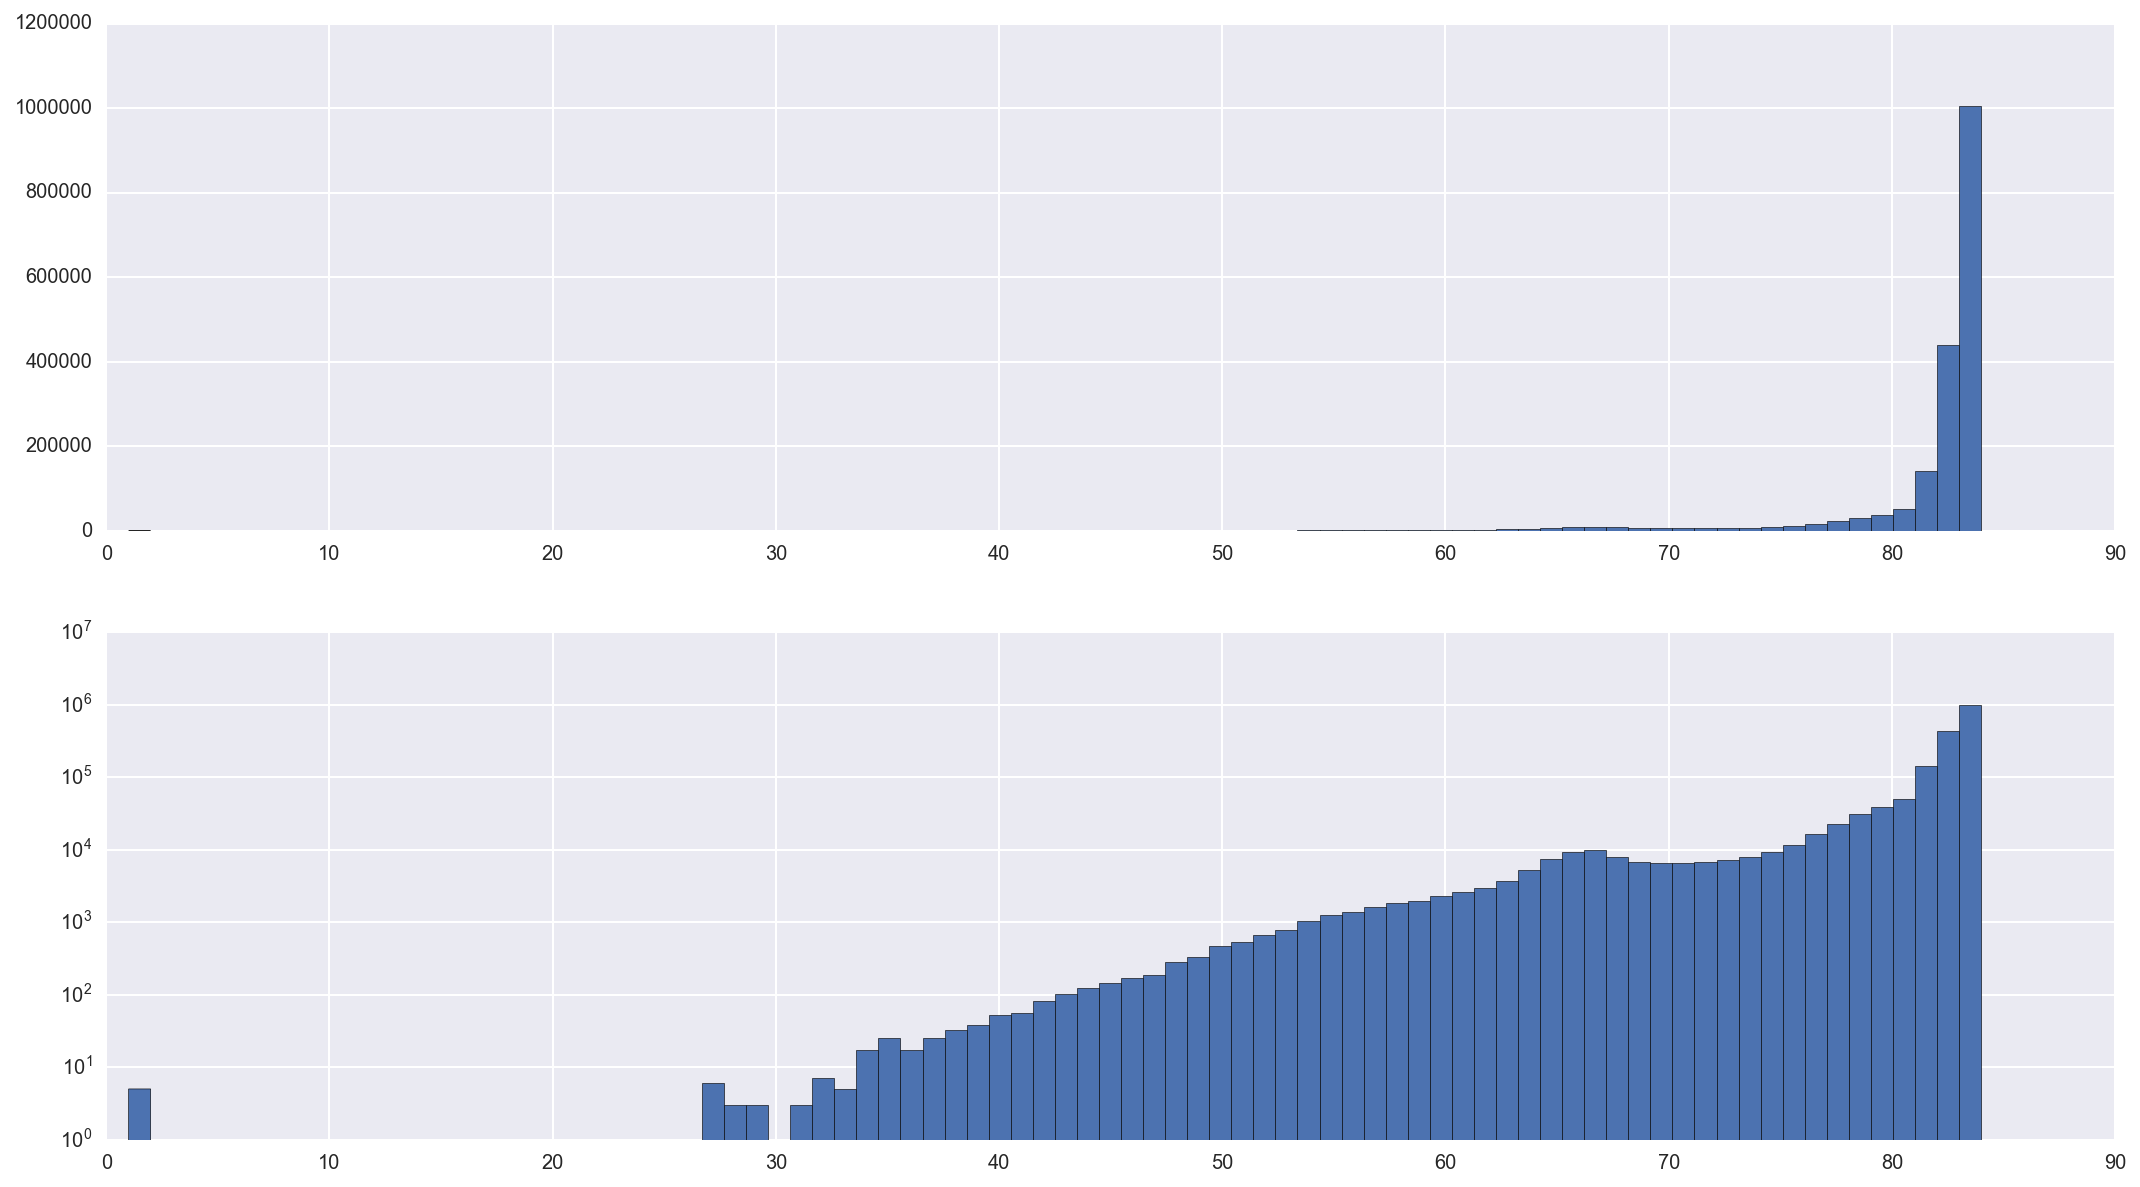

In [130]:
enerpi_samples = enerpidata.ref
print_info(enerpi_samples.describe())

f, axes = plt.subplots(2, 1, figsize=(18, 10))
enerpi_samples.hist(bins=84, ax=axes[0])
enerpi_samples.hist(bins=84, ax=axes[1], log=True)

# Señal senoidal ideal

**Simulación de la señal que muestrea la sonda mediante el MCP3008.**

* Se construye una señal senoidal perfecta en base a un valor de potencia RMS
* Se procede al sampling en base al conversor utilizado, de 10 bits de resolución, y al circuito sensor utilizado.

In [143]:
def _perfect_constant_signal(P_rms=550):
    I_rms = P_rms / V
    I_sampled = I_rms / I_ref
    x = np.linspace(0, T, num=T / step + 1)
    y = (V_ref / 2 + I_sampled * np.sqrt(2) * np.sin(2* np.pi * x * freq)) / V_ref
    return x, y


def _prec_sampling_error(values):
    return [round(x * niveles, 0) / niveles for x in values]


def _muestreo_perfecto(sampling_ms, x_ref, y_ref):
    """
    Inicia con un offset de 0 a "sampling_ms" y, a partir de ahí, 
    realiza un sampling perfecto a la señal de referencia cada "sampling_ms" (No comete errores).
    """
    sampling_step = int(sampling_ms / (1000 * step))
    x_sampler = int(random.randrange(0, sampling_ms, 1) / (1000 * step))
    N = len(y_ref)
    x_samples, y_samples = [], []
    while x_sampler < N:
        x_samples.append(x_ref[x_sampler])
        y_samples.append(y_ref[x_sampler])
        x_sampler += sampling_step
    return x_samples, y_samples


def _rms_value(raw_samples, verbose=False):
    rms = np.sqrt(np.mean([(x - resta_bias)**2 for x in raw_samples])) * V * 30
    if verbose:
        print_red('RMS = {:.2f} (N={})'.format(rms, len(raw_samples)))
    return rms


def _enerpi_sampling(readings):
    buffer = []
    counter_frames = counter_buffer = cumsum = 0
    for v in readings:
        counter_buffer += 1
        counter_frames += 1
        buffer.append((v - resta_bias) ** 2)
        cumsum += np.mean(buffer)
    power = np.sqrt(cumsum / counter_buffer) * V * I_ref * V_ref
    return power


#def simu_sampling(raw_samples, num_sims):
#    samples = [_rms_value(raw_samples) for _ in range(num_sims)]
#    return samples
    

freq = 50  # Hz
V = 236  # Voltaje RMS
I_ref = 30  # A para 1 V (SCT030-030)

MCP3008_DAC_PREC = 10
RMS_ROLL_WINDOW_SEC = 2
V_ref = 3.3  # V ref en RPI
niveles = 2 ** MCP3008_DAC_PREC - 1
resta_bias = (niveles // 2) / niveles

sampling_ms = 12
roll_time = RMS_ROLL_WINDOW_SEC
s_calc = sampling_ms if sampling_ms > 0 else 8
n_samples = int(round(roll_time * 1000 / s_calc))
print_info('Sampling = {} ms; Roll time = {} s ==> Buffer N samples = {}'.format(sampling_ms, roll_time, n_samples))

Sampling = 12 ms; Roll time = 2 s ==> Buffer N samples = 167


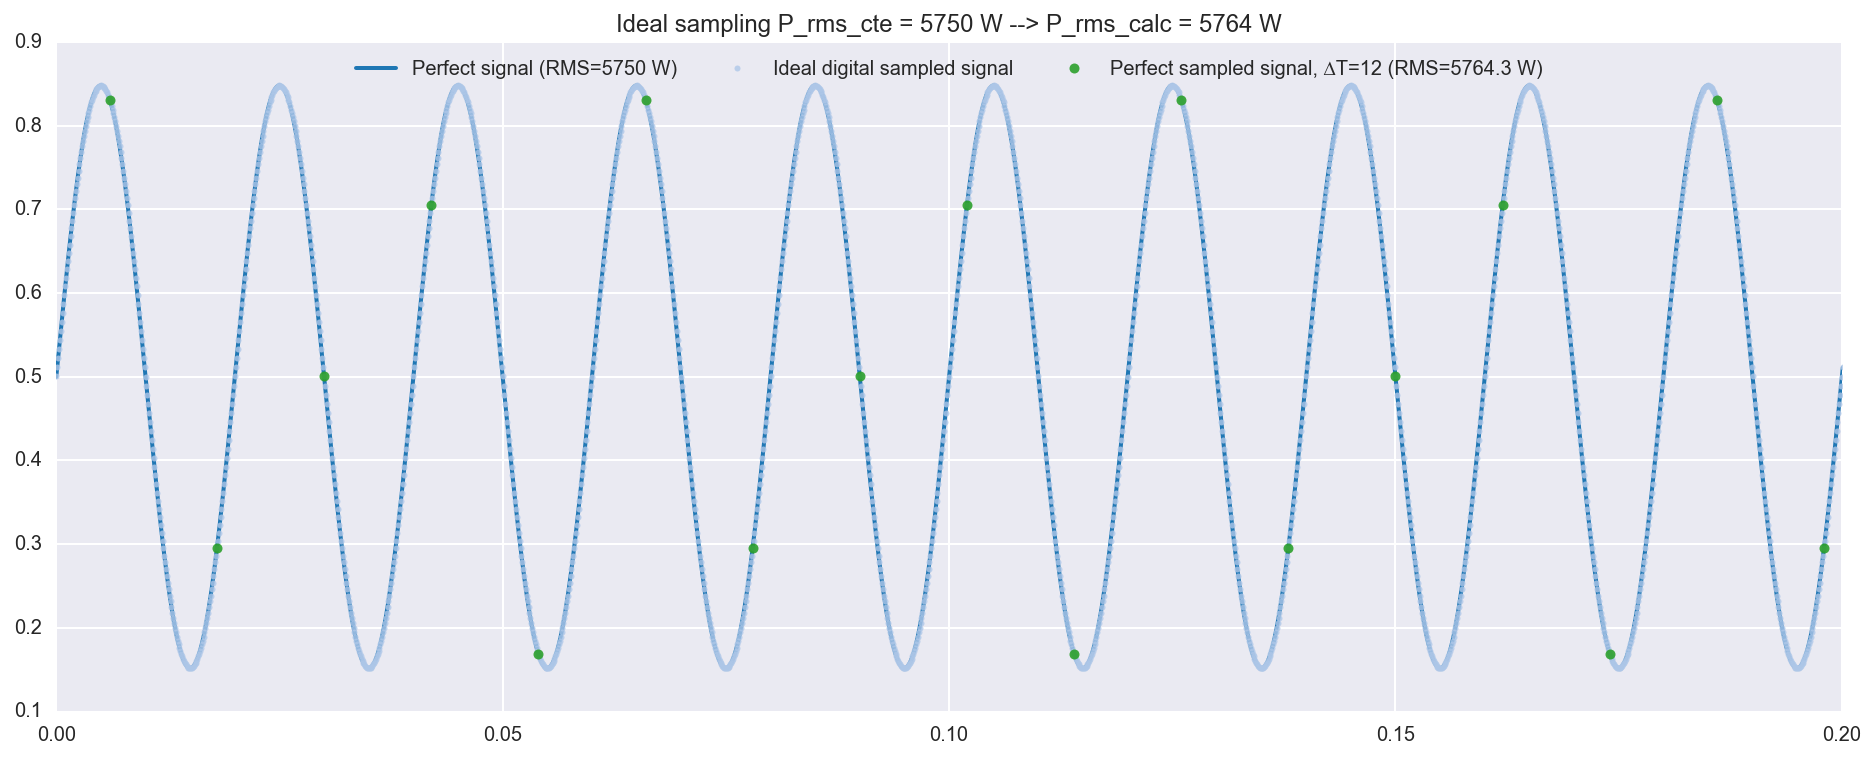

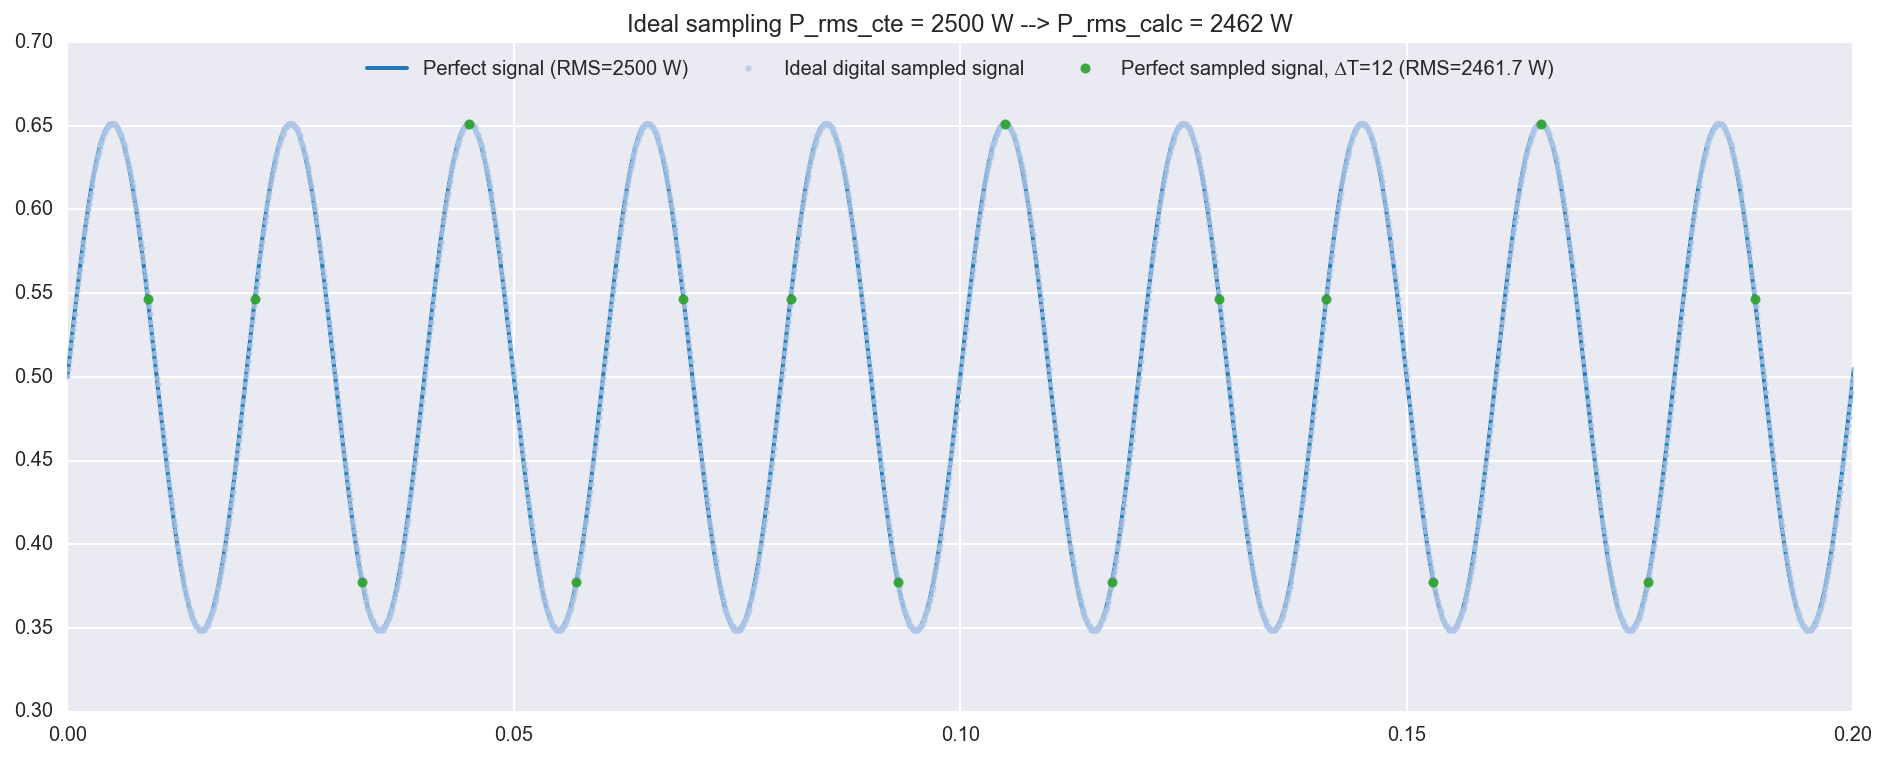

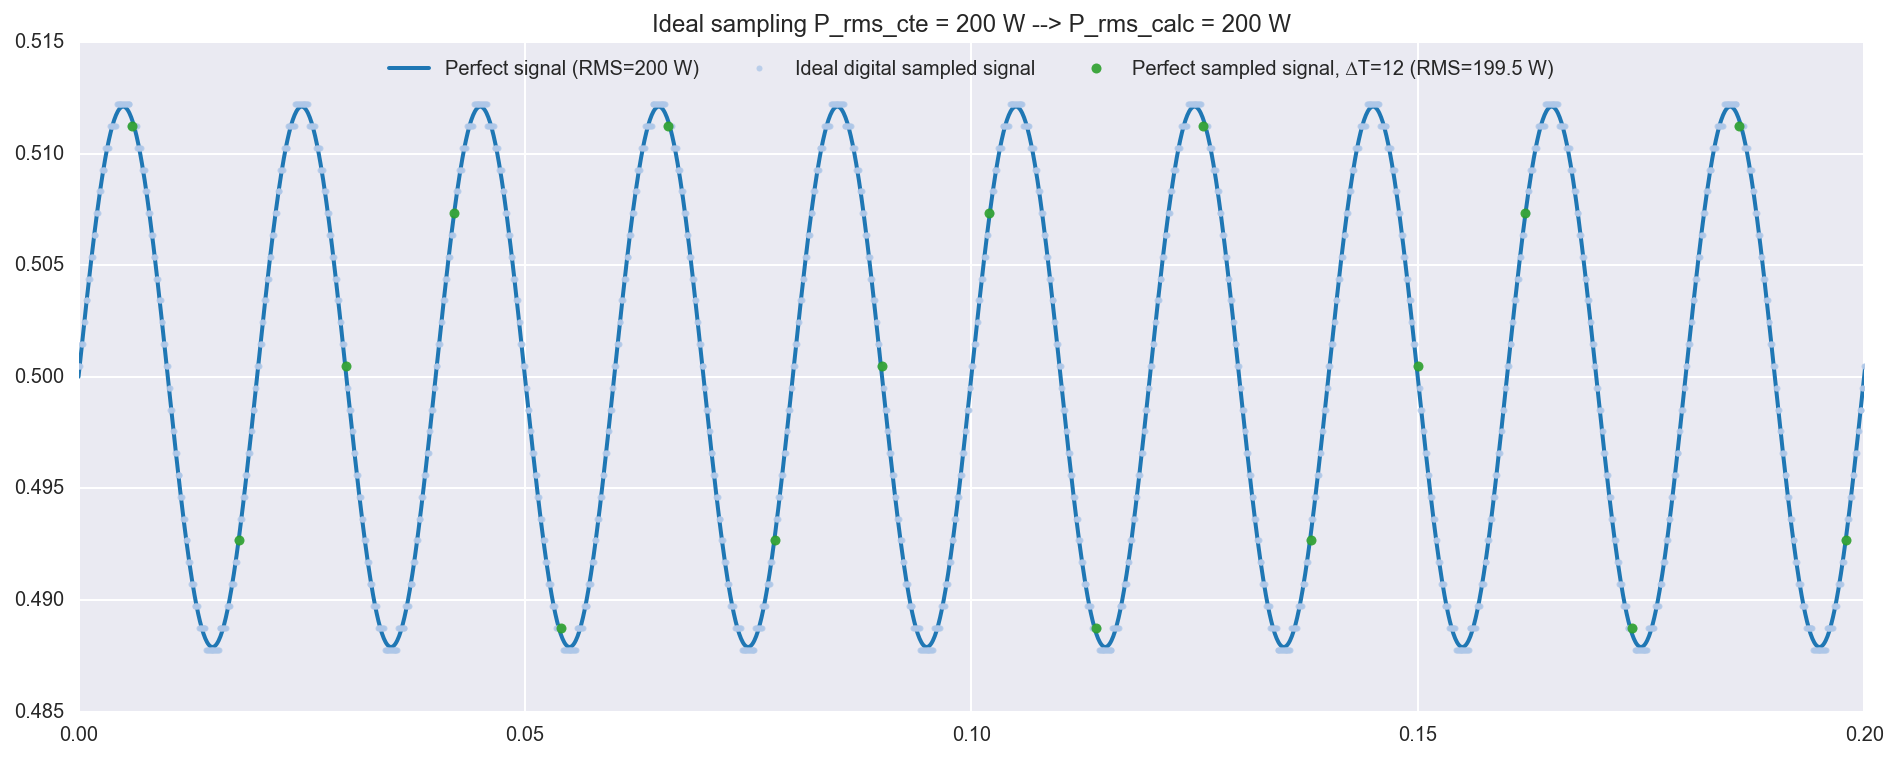

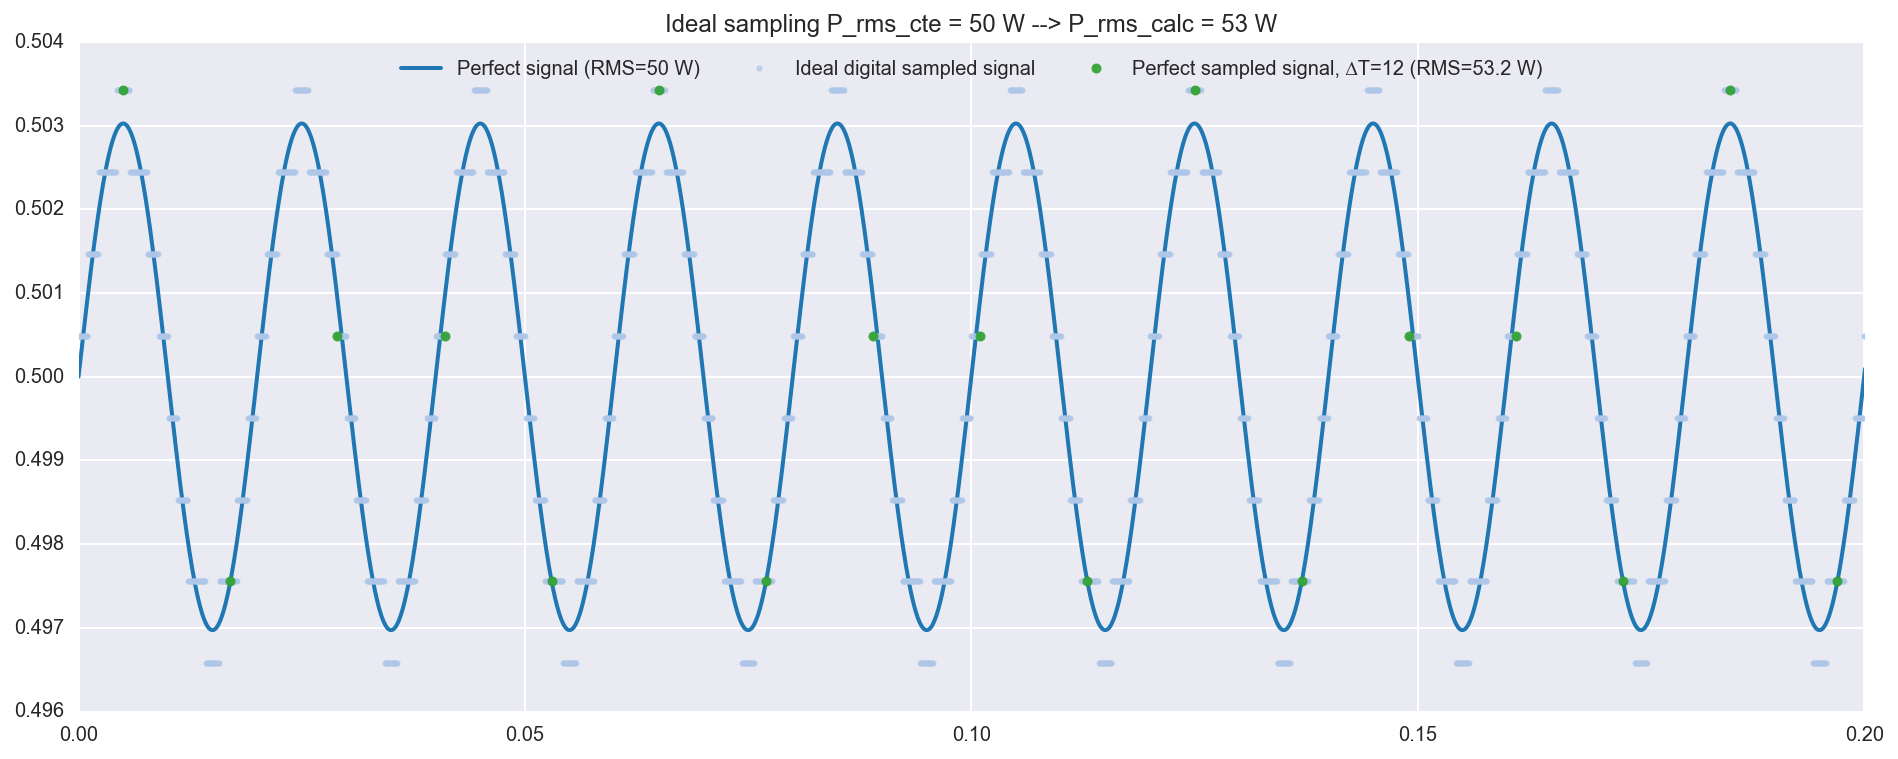

In [146]:
T = 2  # s
step = .0001  # s = 100µs

# Ejemplos con 4250 y 250 W:
P_rms = [5750, 2500, 200, 50]

for pot in P_rms:
    x, y_perfect = _perfect_constant_signal(pot)
    y = _prec_sampling_error(y_perfect)
    xs, ys = _muestreo_perfecto(sampling_ms, x, y)
    rms_calc = _enerpi_sampling(ys)
    
    plt.subplots(1, 1, figsize=(16, 6))
    plt.plot(x, y_perfect, color=tableau20[0], lw=2, label='Perfect signal (RMS={} W)'.format(pot))
    plt.plot(x, y, color=tableau20[1], lw=0, marker='o', markersize=3, alpha=.8, label='Ideal digital sampled signal')
    plt.plot(xs, ys, color=tableau20[4], lw=0, marker='o', markersize=5, alpha=.9, 
             label='Perfect sampled signal, ∆T={} (RMS={:.1f} W)'.format(sampling_ms, rms_calc))
    plt.xlim((0, .2))
    plt.title('Ideal sampling P_rms_cte = {} W --> P_rms_calc = {:.0f} W'.format(pot, rms_calc))
    plt.legend(loc='upper center', ncol=3)
    plt.show()

In [160]:
@timeit('simula_enerpi_sampling')
def simula_enerpi_sampling(P_rms, N_simul=1000):
    d_simuls = {}
    for pot in P_rms:
        x, y_perfect = _perfect_constant_signal(pot)
        y = _prec_sampling_error(y_perfect)
        rms_calc = [_enerpi_sampling(_muestreo_perfecto(sampling_ms, x, y)[1]) for _ in range(N_simul)]
        d_simuls[pot] = rms_calc
    return d_simuls
    
    
d_simuls = simula_enerpi_sampling(P_rms, 10000)

simula_enerpi_sampling TOOK: 96.198 s


MEAN of 10000 sims -> 201.8 W RMS (∆=1.8)
MEAN of 10000 sims -> 48.6 W RMS (∆=-1.4)
MEAN of 10000 sims -> 2496.7 W RMS (∆=-3.3)
MEAN of 10000 sims -> 5748.3 W RMS (∆=-1.7)


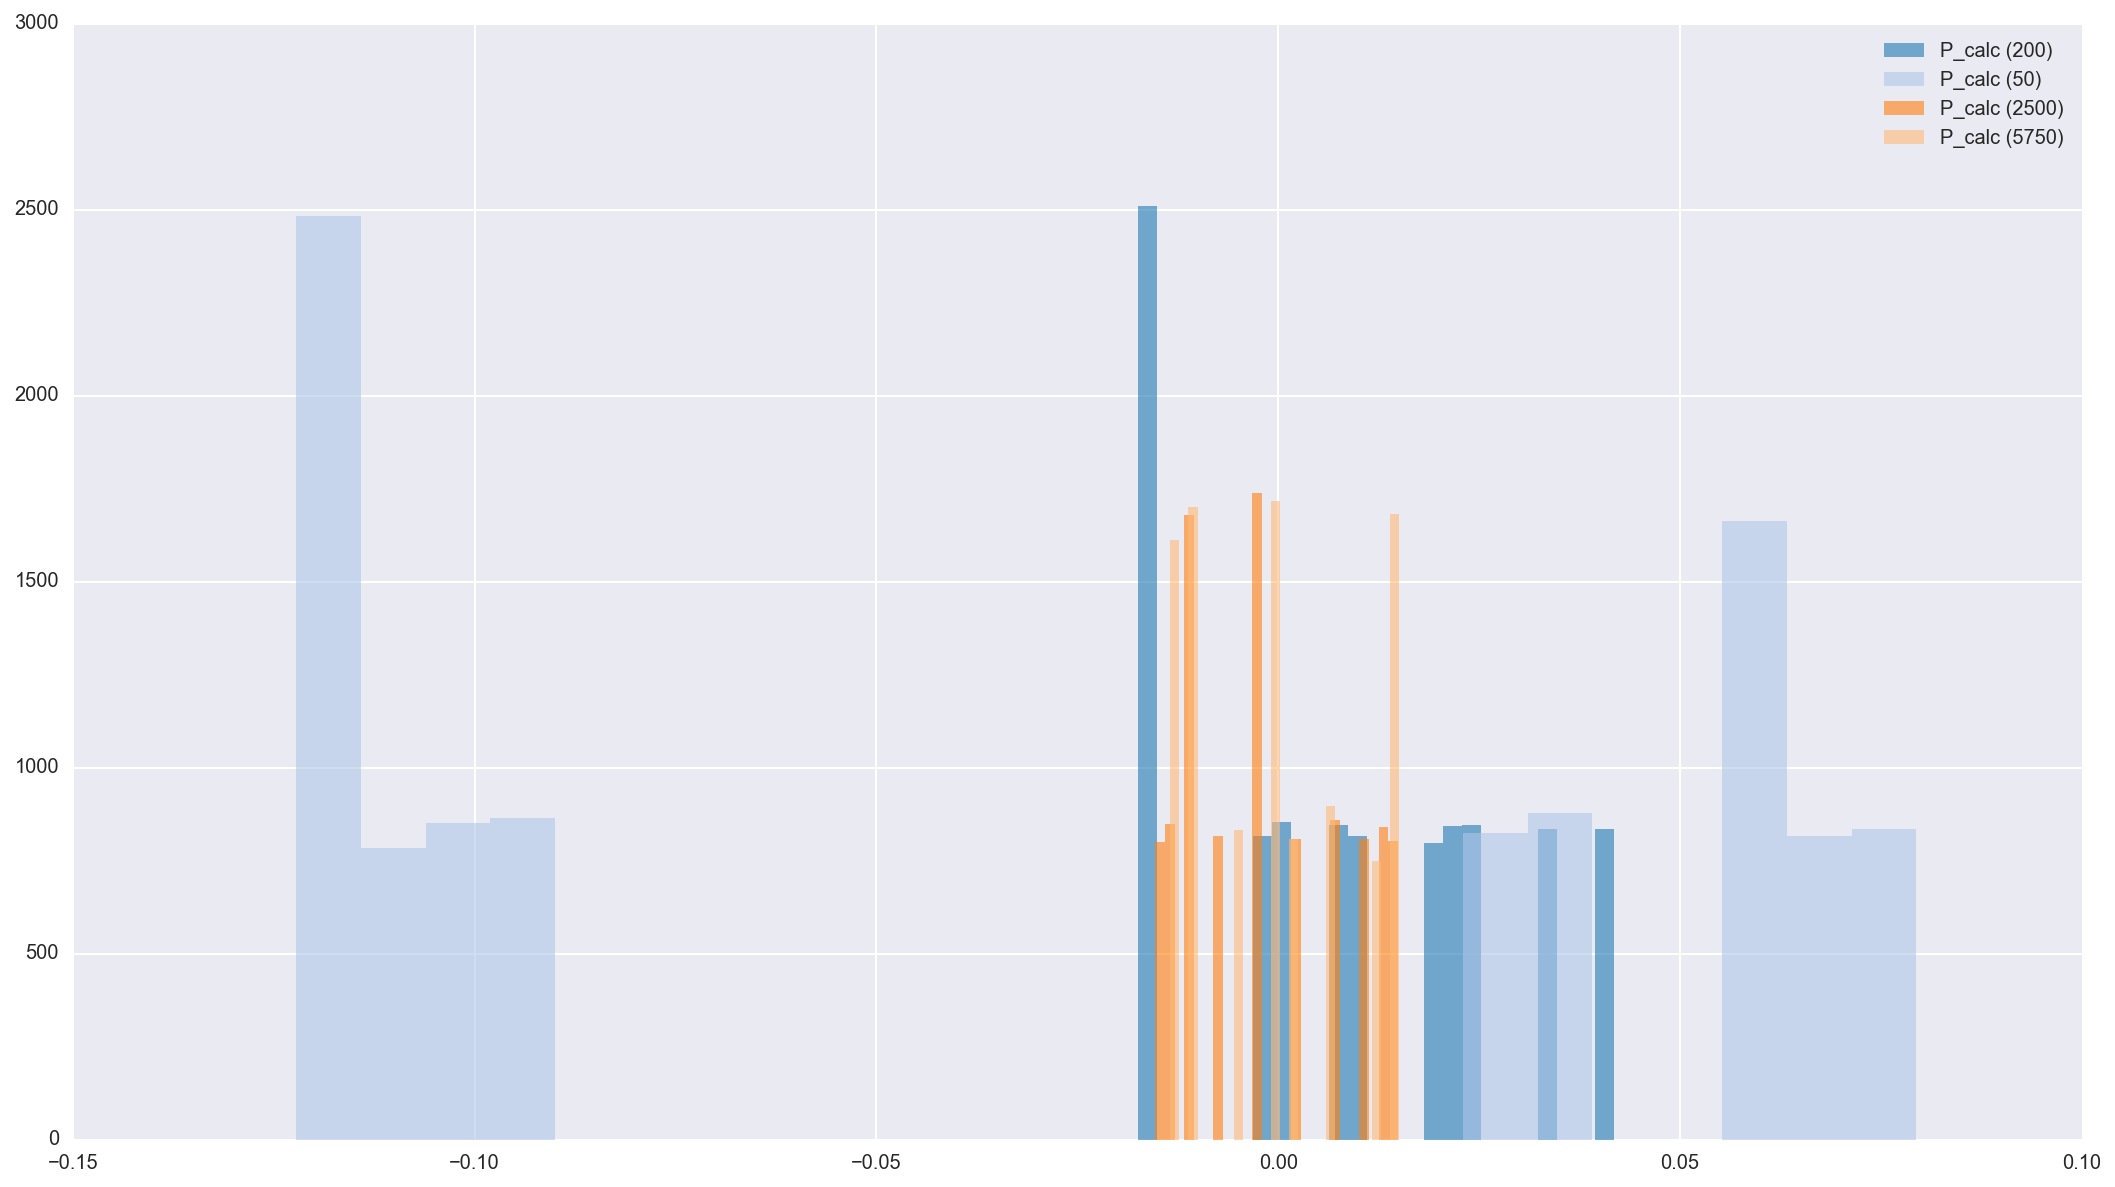

In [188]:
def plot_histogram_data(data, label='values', ind_color=0, bins=100):
    hist, bins = np.histogram(data, bins=bins)
    width = 1. * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    return plt.bar(center, hist, align='center', width=width, lw=0, color=tableau20[ind_color], alpha=.6, label=label)
    

    
bins_hist_porc = np.linspace(-.5, .5, .01)
plt.subplots(1, 1, figsize=(18, 10))
for i, (pot, values) in enumerate(d_simuls.items()):
    print_red('MEAN of {} sims -> {:.1f} W RMS (∆={:.1f})'.format(len(values), np.mean(values), np.mean(values) - pot))
    plot_histogram_data((np.array(values) - pot) / pot, label='P_calc ({})'.format(pot), ind_color=i, bins=25)
    #break
#ymax = plt.gca().get_ylim()[1]
#for i, pot in enumerate(d_simuls.keys()):
    #plt.vlines([pot], 0, [ymax], label='P={}'.format(pot), colors=['grey'], lw=1, alpha=.6)
    #break
plt.legend();

In [184]:
pot = 200
pd.Series((np.array(d_simuls[pot]) - pot) / pot, name=pot).hist?

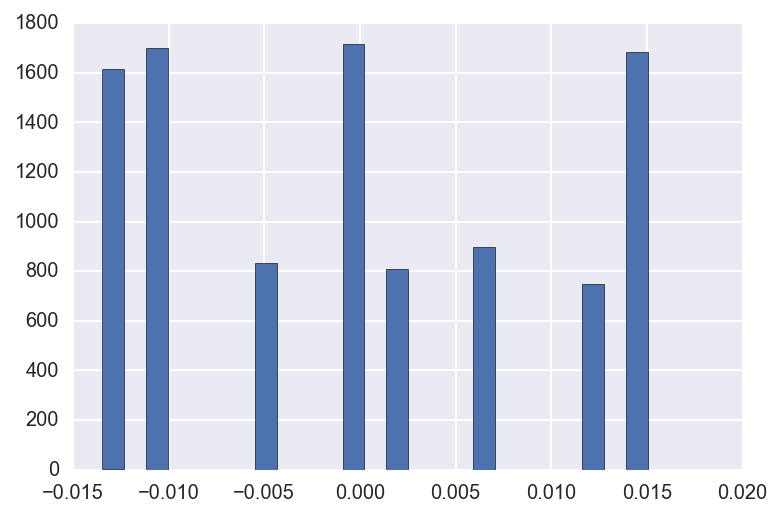

In [189]:
pd.Series((np.array(d_simuls[pot]) - pot) / pot, name=pot).hist(bins=25)

In [176]:
from collections import deque


N_SAMPLES_BUFFER = 167  # Nº de samples tenidos en cuenta para calcular el RMS instantáneo
DELTA_SEC_DATA = 1
PREC_SAMPLING = 500 # µs


# generación unitaria de valor:
def enerpi_sample(t_µs, p_rms):
    y = (V_ref / 2 + ((p_rms / V) / I_ref) * np.sqrt(2) * np.sin(2* np.pi * freq * t_µs / 1e6)) / V_ref
    return round(y * niveles, 0) / niveles


def _func_power_cte(time_µs, p=500):
    return p


def _func_power_step(time_µs, p_i=500, p_f=2500, t_step=5):
    if time_µs / 1e6 > t_step:
        return p_f
    return p_i


def _func_power_multi_step(time_µs, p_i=500, p_1=1500, p_2=2500, t_step=5, t_phase=5):
    if time_µs / 1e6 > t_step:
        n = ((time_µs / 1e6) - t_step) / t_phase
        if int(n) % 2 == 0:
            return p_2
        return p_1
    return p_i


def _enerpi_sampler_rms(n_samples_buffer=N_SAMPLES_BUFFER, 
                        delta_sampling=DELTA_SEC_DATA, 
                        t_simulacion_seg=10,
                        time_generator=None, 
                        func_power_rms=_func_power_cte, **kwargs_func_power):
    """
    :param n_samples_buffer: Nº de samples tenidos en cuenta para calcular el RMS instantáneo.
    :param delta_sampling: ∆T en segundos entre envíos de información (yielding)
    :param min_ts_ms: ∆T en ms mínimo entre samples. Por defecto a 0: el máximo nº de frames que pueda computarse.

    :yield: (ts_datetime, power_rms)
    """
    data_yield, data_raw = [], []
    delta_sampling_calc = delta_sampling * 1e6
    buffer = deque(np.zeros(n_samples_buffer), n_samples_buffer)
    niveles = 2 ** MCP3008_DAC_PREC - 1
    resta_bias = (niveles // 2) / niveles
    t_µs = stop = 0
    counter_frames = counter_buffer = cumsum = 0
    while t_µs < t_simulacion_seg * 1e6:
        counter_buffer += 1
        counter_frames += 1
        t_µs = next(time_generator)
        p_rms = func_power_rms(t_µs, **kwargs_func_power)
        value = enerpi_sample(t_µs, p_rms)
        data_raw.append((t_µs, value))
        buffer.append((value - resta_bias) ** 2)
        if counter_frames < n_samples_buffer:
            cumsum += np.mean([buffer[i] for i in range(-counter_frames, 0)])
        else:
            cumsum += np.mean(buffer)
        if t_µs - stop > delta_sampling_calc - PREC_SAMPLING:
            power = np.sqrt(cumsum / counter_buffer) * V * I_ref * V_ref
            #yield (power, counter_buffer, t_µs / 1e6, p_rms)
            data_yield.append((power, counter_buffer, t_µs / 1e6, p_rms))
            counter_buffer = cumsum = 0
            stop = t_µs
    return data_yield, data_raw


def _time_generator(sampling_ms, perfect_freq=True):
    sampling_step = sampling_ms * 1e3
    x_sampler = random.randrange(0, sampling_ms, 1) * 1e3 + 1e5
    print(sampling_step, x_sampler)
    yield x_sampler
    while True:
        if perfect_freq:
            x_sampler += sampling_step
        else:  # Sampling más caótico:
            x_sampler += sampling_step + random.randrange(-sampling_ms // 3, sampling_ms // 3) * 1e2
        yield x_sampler

        
freq = 50  # Hz
V = 236  # Voltaje RMS
I_ref = 30  # A para 1 V (SCT030-030)

MCP3008_DAC_PREC = 10
RMS_ROLL_WINDOW_SEC = 2
V_ref = 3.3  # V ref en RPI
niveles = 2 ** MCP3008_DAC_PREC - 1
resta_bias = (niveles // 2) / niveles

sampling_ms = 12
roll_time = RMS_ROLL_WINDOW_SEC
s_calc = sampling_ms if sampling_ms > 0 else 8
n_samples = int(round(roll_time * 1000 / s_calc))
print_info('Sampling = {} ms; Roll time = {} s ==> Buffer N samples = {}'.format(sampling_ms, roll_time, n_samples))

Sampling = 12 ms; Roll time = 2 s ==> Buffer N samples = 167


12000.0 103000.0


,power,ref,ts,p_ref
0,512.498926,77,1.0114,500
1,500.796703,84,2.0160,500
2,498.360367,84,3.0176,500
3,497.181571,84,4.0216,500
4,506.630644,84,5.0274,2500
5,1889.530324,84,6.0336,2500
6,2524.731115,84,7.0362,2500
7,2494.512783,84,8.0395,2500
8,2497.698852,84,9.0403,2500
9,2503.933977,84,10.0448,1500


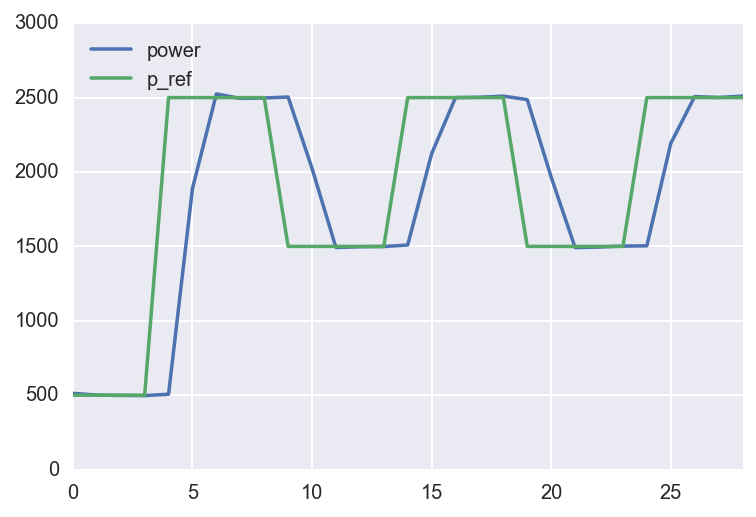

In [177]:
data, raw = _enerpi_sampler_rms(n_samples_buffer=84, delta_sampling=DELTA_SEC_DATA, 
                                t_simulacion_seg=30, 
                                time_generator=_time_generator(sampling_ms, perfect_freq=False), 
                                func_power_rms=_func_power_multi_step)

raw = pd.DataFrame(raw, columns=['tt', 'v']).set_index('tt')

df = pd.DataFrame(data, columns=['power', 'ref', 'ts', 'p_ref'])
df[['power', 'p_ref']].plot()
df.head(10)

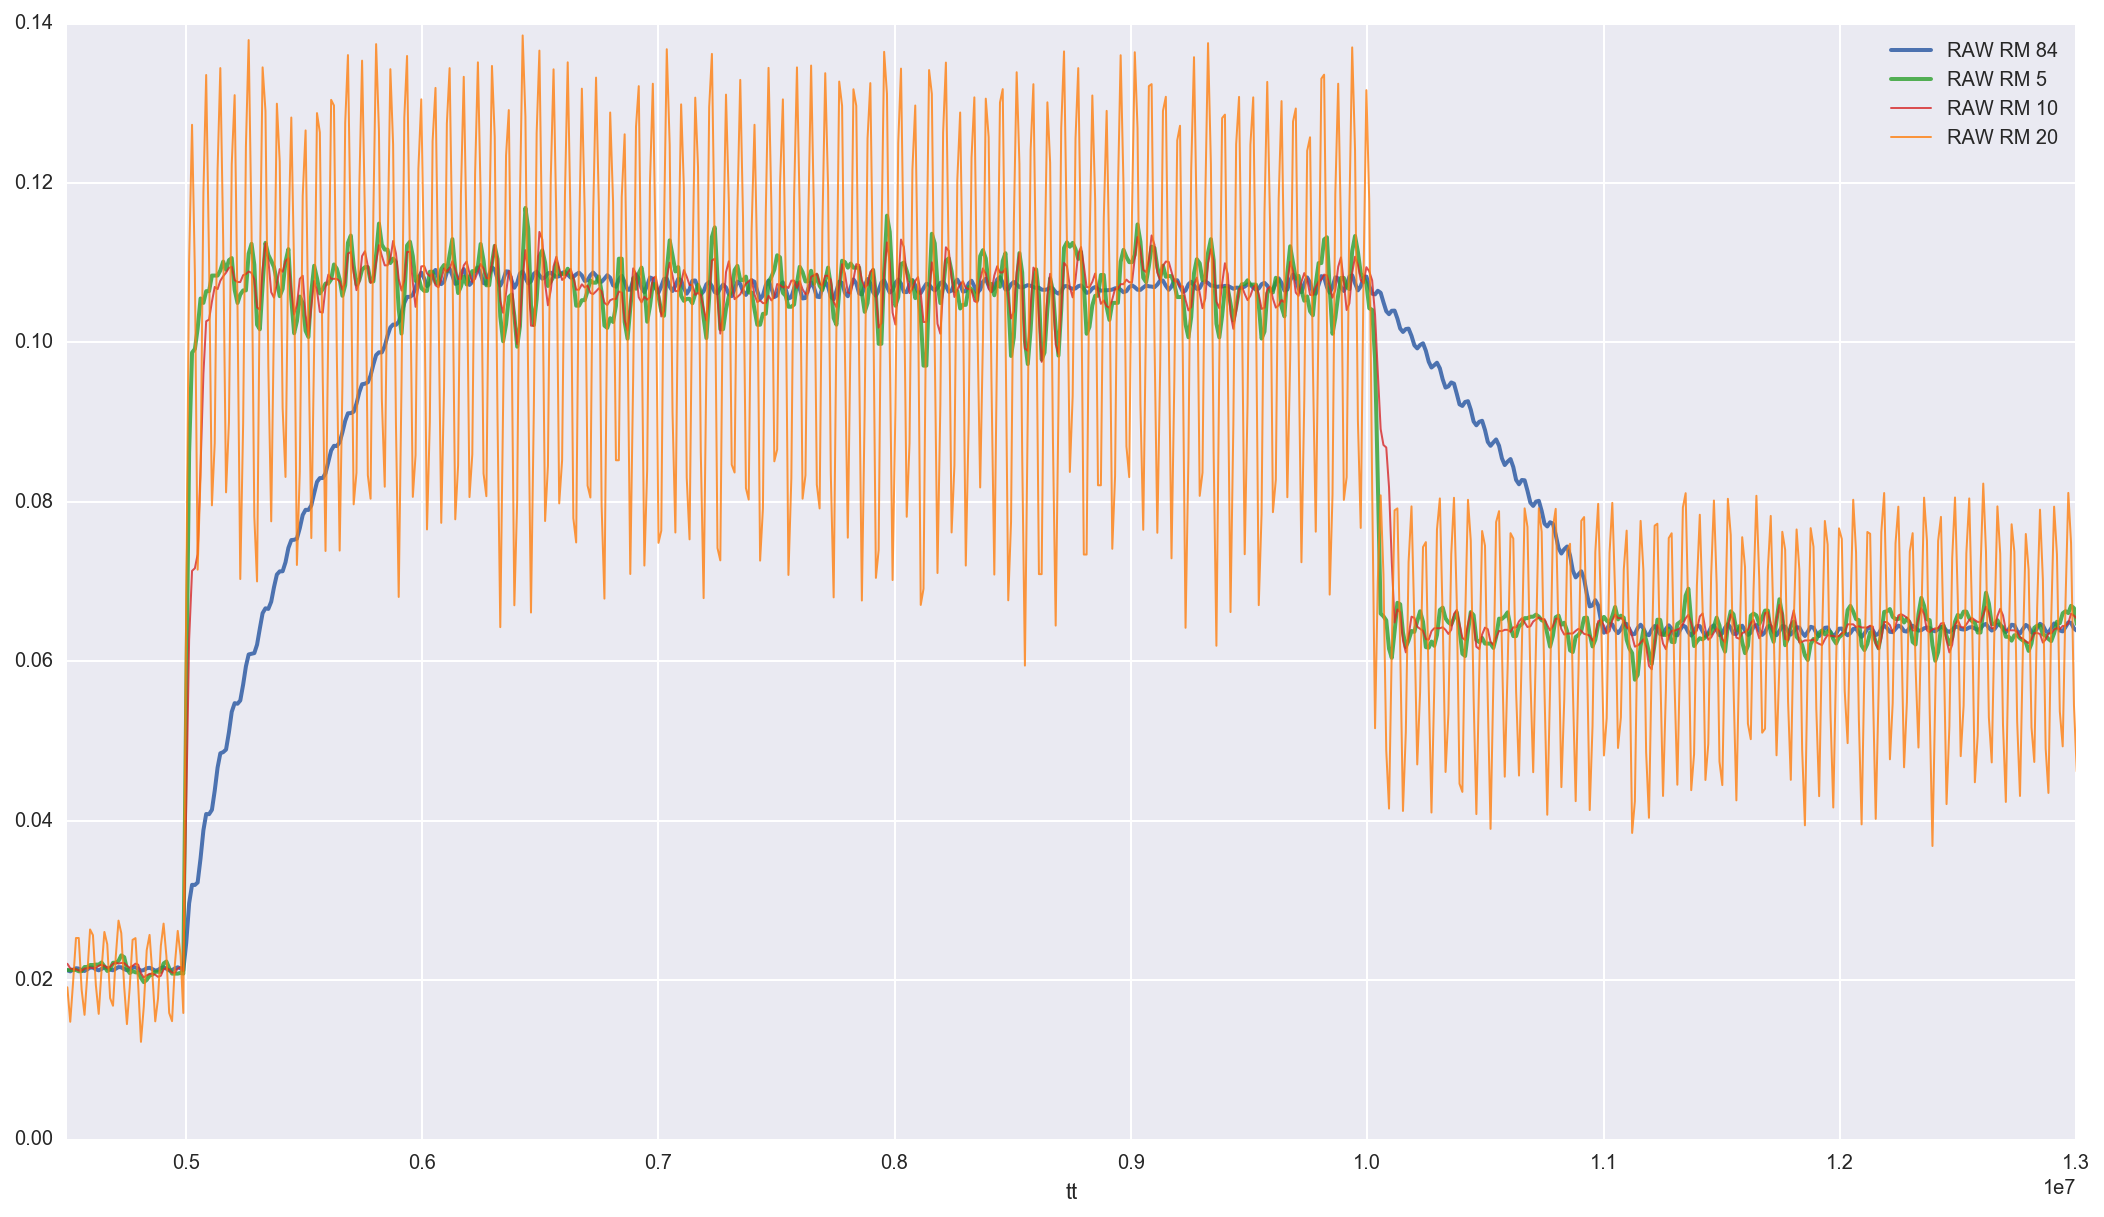

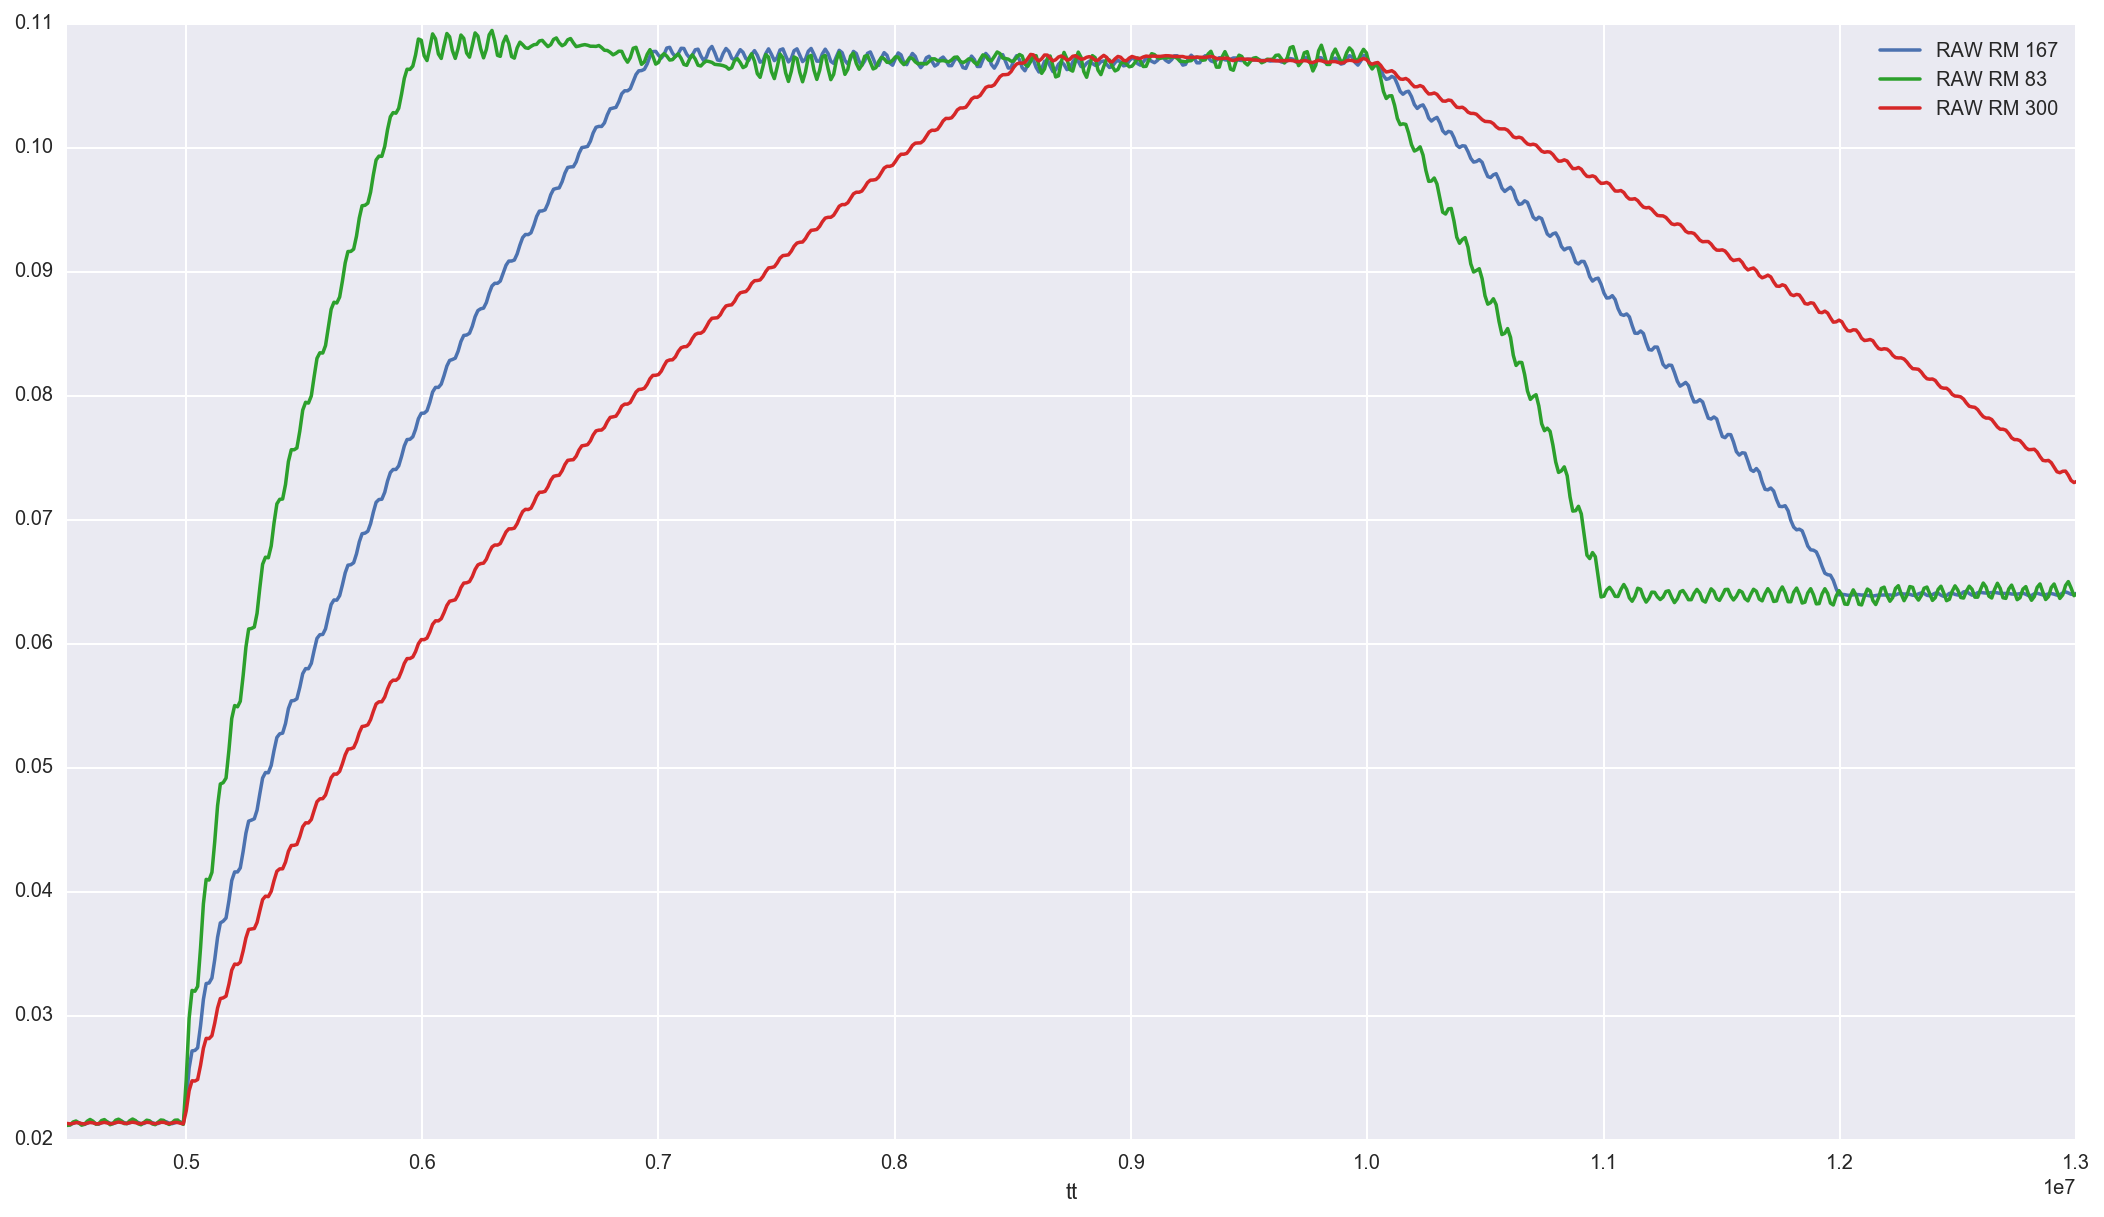

(4500000.0, 6000000.0)

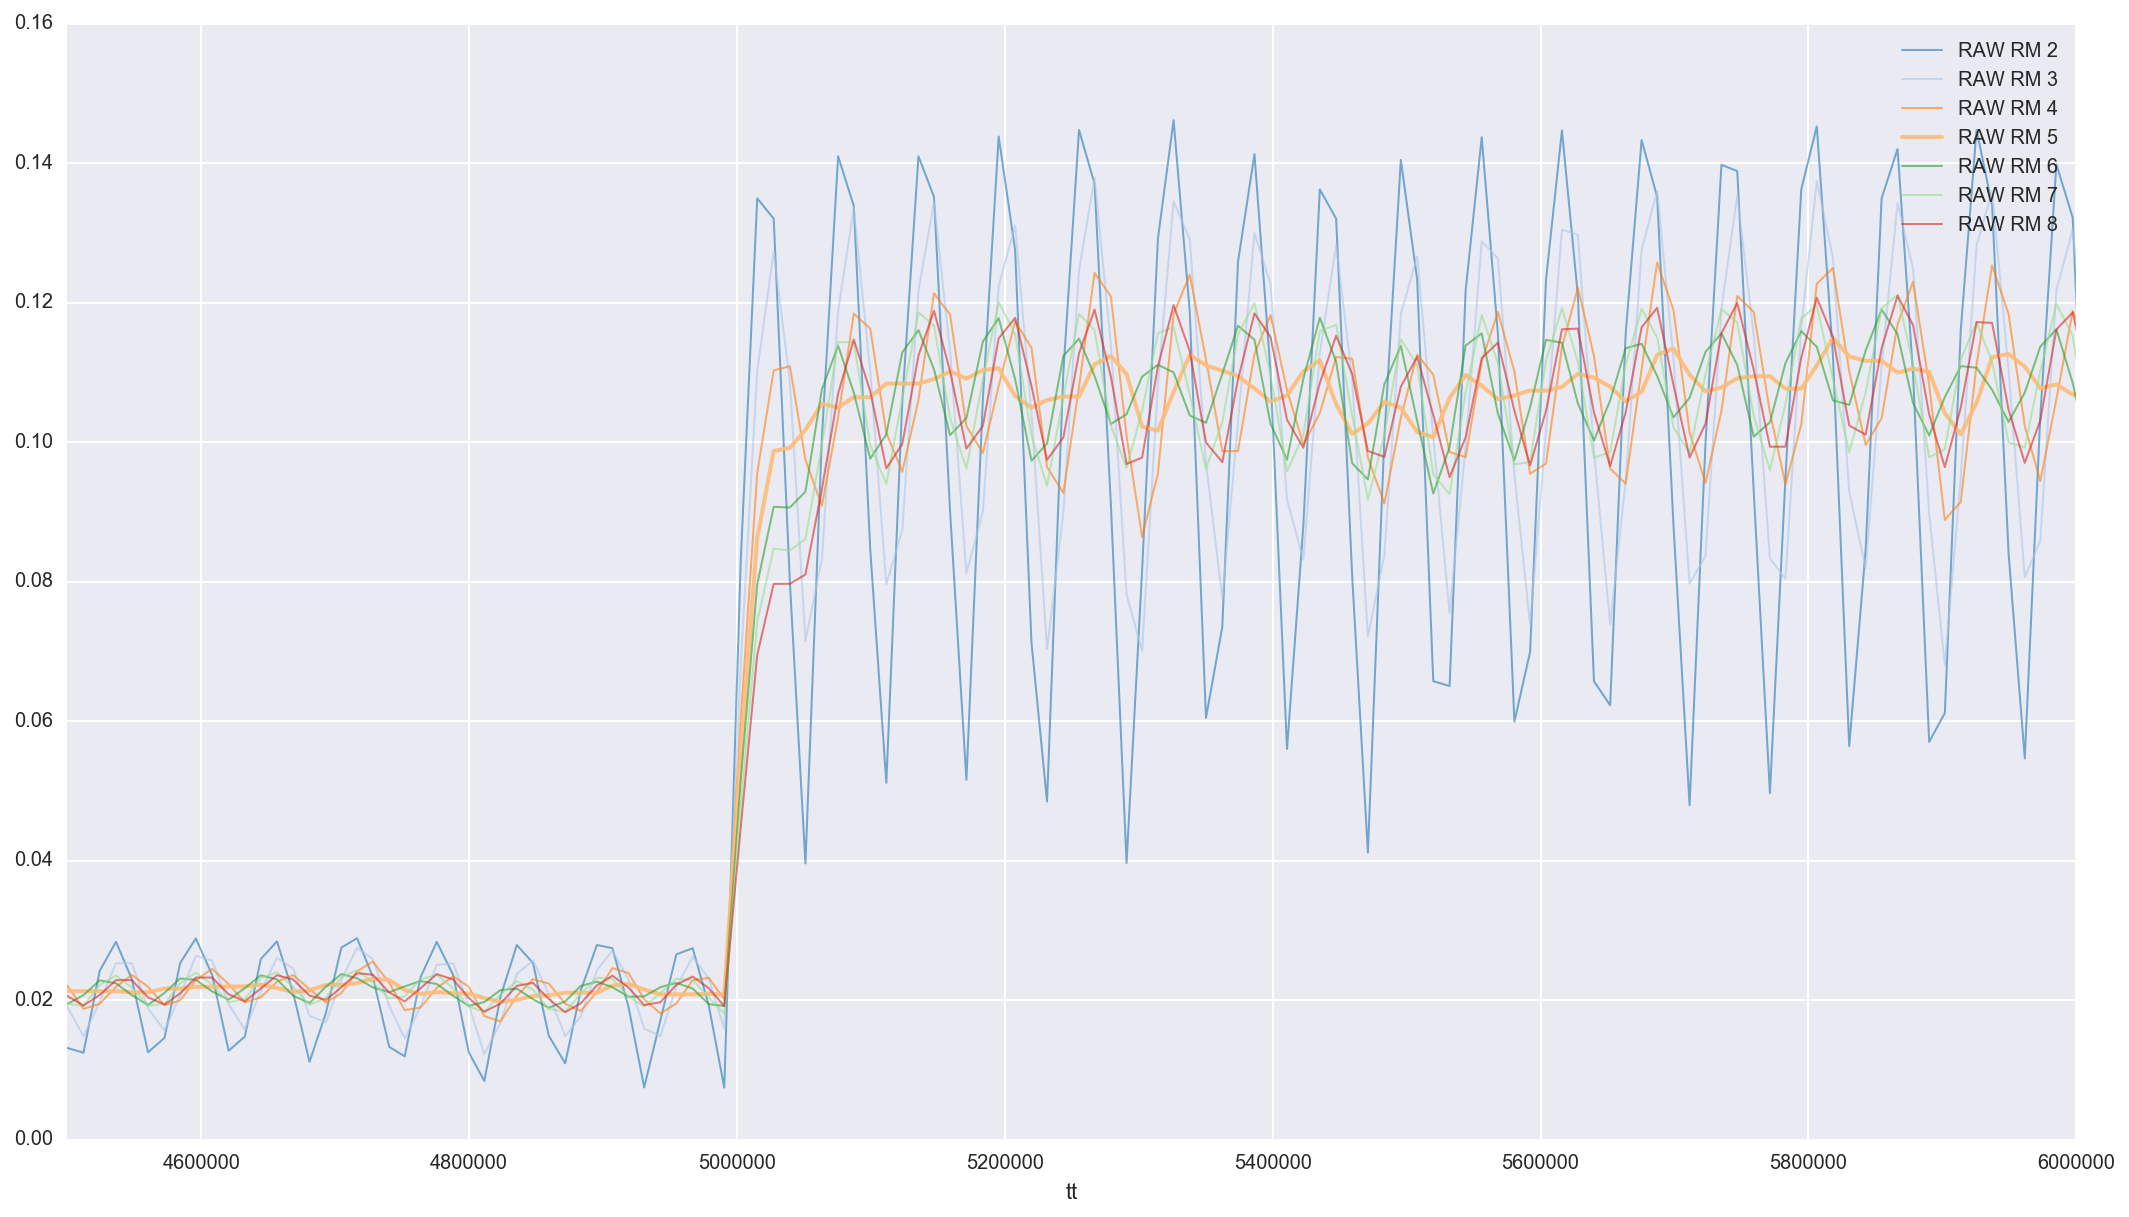

In [178]:
raw_abs_cuad = raw.apply(lambda x: (x - resta_bias)**2)['v']

ax = raw_abs_cuad.rename('RAW RM 84').rolling(84).mean().apply(np.sqrt).plot(figsize=(18, 10), lw=2)
raw_abs_cuad.rename('RAW RM 5').rolling(5).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[4], lw=2, alpha=.8)
raw_abs_cuad.rename('RAW RM 10').rolling(10).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[6], lw=1, alpha=.8)
raw_abs_cuad.rename('RAW RM 20').rolling(3).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[2], lw=1, alpha=.8)
plt.legend()
ax.set_xlim((.45e7, 1.3e7))
plt.show()

ax = raw_abs_cuad.rename('RAW RM 167').rolling(167).mean().apply(np.sqrt).plot(figsize=(18, 10))
raw_abs_cuad.rename('RAW RM 83').rolling(83).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[4])
raw_abs_cuad.rename('RAW RM 300').rolling(300).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[6])
plt.legend()
ax.set_xlim((.45e7, 1.3e7))
plt.show()

ax = raw_abs_cuad.rename('RAW RM 2').rolling(2).mean().apply(np.sqrt).plot(figsize=(18, 10), color=tableau20[0], lw=1, alpha=.6)
raw_abs_cuad.rename('RAW RM 3').rolling(3).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[1], lw=1, alpha=.6)
raw_abs_cuad.rename('RAW RM 4').rolling(4).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[2], lw=1, alpha=.6)
raw_abs_cuad.rename('RAW RM 5').rolling(5).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[3], lw=2, alpha=.9)
raw_abs_cuad.rename('RAW RM 6').rolling(6).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[4], lw=1, alpha=.6)
raw_abs_cuad.rename('RAW RM 7').rolling(7).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[5], lw=1, alpha=.6)
raw_abs_cuad.rename('RAW RM 8').rolling(8).mean().apply(np.sqrt).plot(ax=ax, color=tableau20[6], lw=1, alpha=.6)
plt.legend()
ax.set_xlim((.45e7, .6e7))

running sampler with sampling_ms=12, n_samples_buffer=10
12000.0 101000.0
         power  ref       ts  p_ref          new          tt
0   497.144752   77   1.0099    500   499.784508   1009900.0
1   497.597182   84   2.0162    500   497.440734   2016200.0
2   496.066753   84   3.0184    500   495.950808   3018400.0
3   500.166252   84   4.0201    500   500.056577   4020100.0
4   503.082741   84   5.0225   2500   500.777200   5022500.0
5  2449.027264   84   6.0287   2500  2441.403107   6028700.0
6  2507.511087   84   7.0300   2500  2507.060097   7030000.0
7  2500.097794   84   8.0382   2500  2499.545512   8038200.0
8  2500.648132   84   9.0427   2500  2500.260645   9042700.0
9  2501.446600   84  10.0442   1500  2500.572442  10044200.0


,rms,p_ref
tt,,
208600.0,503.385057,500
220400.0,499.014047,500
232400.0,494.393447,500
244400.0,494.393447,500
256600.0,494.393447,500


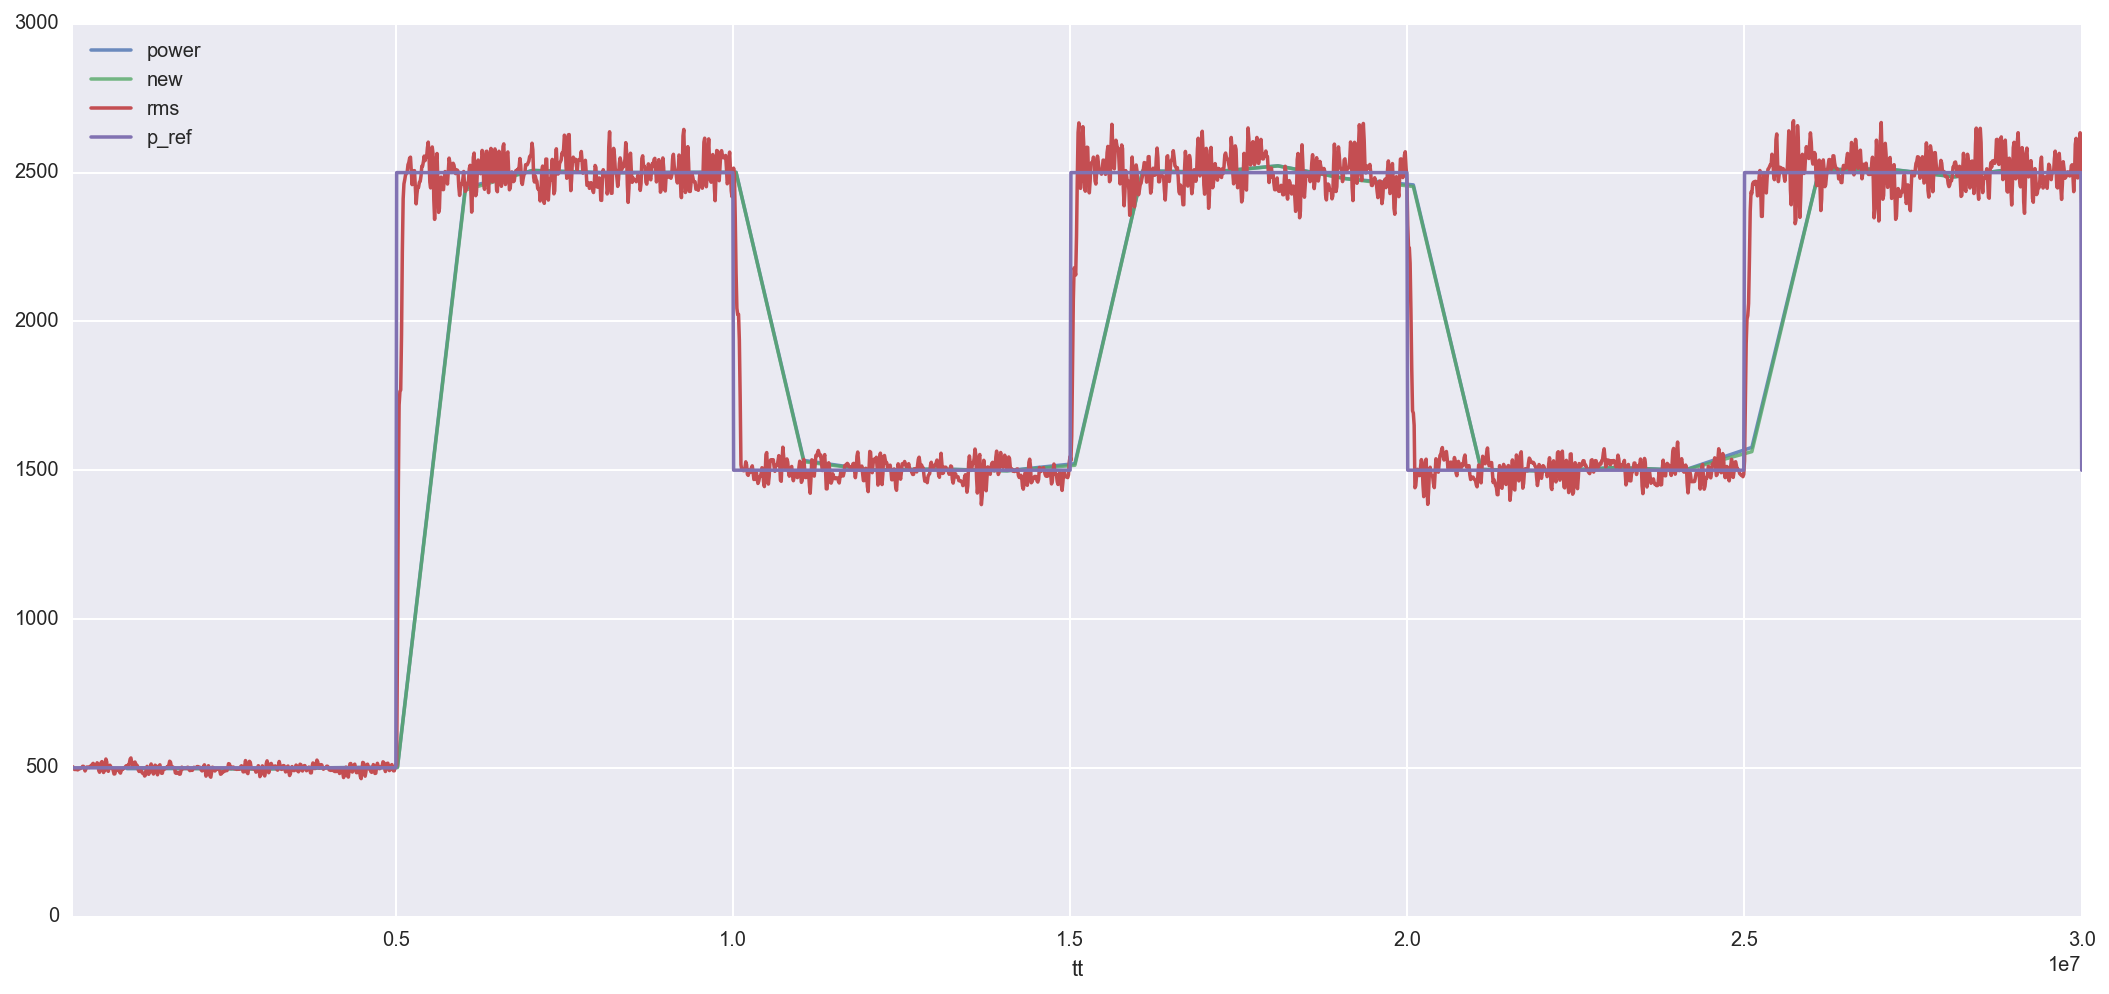

In [179]:
import math


def _enerpi_sampler_rms_auto(sampling_ms, delta_sampling=DELTA_SEC_DATA, 
                             t_simulacion_seg=10, n_rep_buffer=2,
                             time_generator=None, 
                             func_power_rms=_func_power_cte, **kwargs_func_power):
    """
    :param n_samples_buffer: Nº de samples tenidos en cuenta para calcular el RMS instantáneo.
    :param delta_sampling: ∆T en segundos entre envíos de información (yielding)
    :param min_ts_ms: ∆T en ms mínimo entre samples. Por defecto a 0: el máximo nº de frames que pueda computarse.

    :yield: (ts_datetime, power_rms)
    """
    
    T_signal_ms = 1000 // freq
    n_samples_buffer = n_rep_buffer * T_signal_ms // math.gcd(T_signal_ms, sampling_ms)
    print_info('running sampler with sampling_ms={}, n_samples_buffer={}'.format(sampling_ms, n_samples_buffer))
    
    data_yield, data_raw = [], []
    delta_sampling_calc = delta_sampling * 1e6
    buffer = deque(np.zeros(n_samples_buffer), n_samples_buffer)
    niveles = 2 ** MCP3008_DAC_PREC - 1
    resta_bias = (niveles // 2) / niveles
    t_µs = stop = 0
    counter_frames = counter_buffer = cumsum = 0
    buffer_rms_vals, buffer_rms = [], []
    while t_µs < t_simulacion_seg * 1e6:
        counter_buffer += 1
        counter_frames += 1
        t_µs = next(time_generator)
        p_rms = func_power_rms(t_µs, **kwargs_func_power)
        value = enerpi_sample(t_µs, p_rms)
        data_raw.append((t_µs, value))
        buffer.append((value - resta_bias) ** 2)
        if counter_frames < n_samples_buffer:
            cumsum += np.mean([buffer[i] for i in range(-counter_frames, 0)])
        else:
            cumsum += np.mean(buffer)
            buffer_rms_vals.append((t_µs, np.sqrt(np.mean(buffer)) * V * I_ref * V_ref, p_rms))
            buffer_rms.append(np.sqrt(np.mean(buffer)) * V * I_ref * V_ref)
        if t_µs - stop > delta_sampling_calc - PREC_SAMPLING:
            power = np.sqrt(cumsum / counter_buffer) * V * I_ref * V_ref
            #yield (power, counter_buffer, t_µs / 1e6, p_rms)
            data_yield.append((power, counter_buffer, t_µs / 1e6, p_rms, np.mean(buffer_rms)))
            counter_buffer = cumsum = 0
            stop = t_µs
            buffer_rms = []
    return data_yield, data_raw, buffer_rms_vals


data, raw, buffer_rms = _enerpi_sampler_rms_auto(sampling_ms, delta_sampling=DELTA_SEC_DATA, 
                                t_simulacion_seg=30, n_rep_buffer=2,
                                time_generator=_time_generator(sampling_ms, perfect_freq=False), 
                                func_power_rms=_func_power_multi_step)

raw = pd.DataFrame(raw, columns=['tt', 'v']).set_index('tt')
buffer_rms = pd.DataFrame(buffer_rms, columns=['tt', 'rms', 'p_ref']).set_index('tt')

df = pd.DataFrame(data, columns=['power', 'ref', 'ts', 'p_ref', 'new'])
df['tt'] = df['ts'] * 1e6
ax = df[['tt', 'power', 'new']].set_index('tt').plot(figsize=(18, 8), alpha=.8)
buffer_rms.plot(ax=ax)
print(df.head(10))
buffer_rms.head()

running sampler with sampling_ms=12, n_samples_buffer=5
12000.0 101000.0
running sampler with sampling_ms=12, n_samples_buffer=10
12000.0 105000.0
running sampler with sampling_ms=12, n_samples_buffer=15
12000.0 102000.0
running sampler with sampling_ms=12, n_samples_buffer=25
12000.0 103000.0
running sampler with sampling_ms=12, n_samples_buffer=50
12000.0 102000.0
running sampler with sampling_ms=12, n_samples_buffer=100
12000.0 107000.0


/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


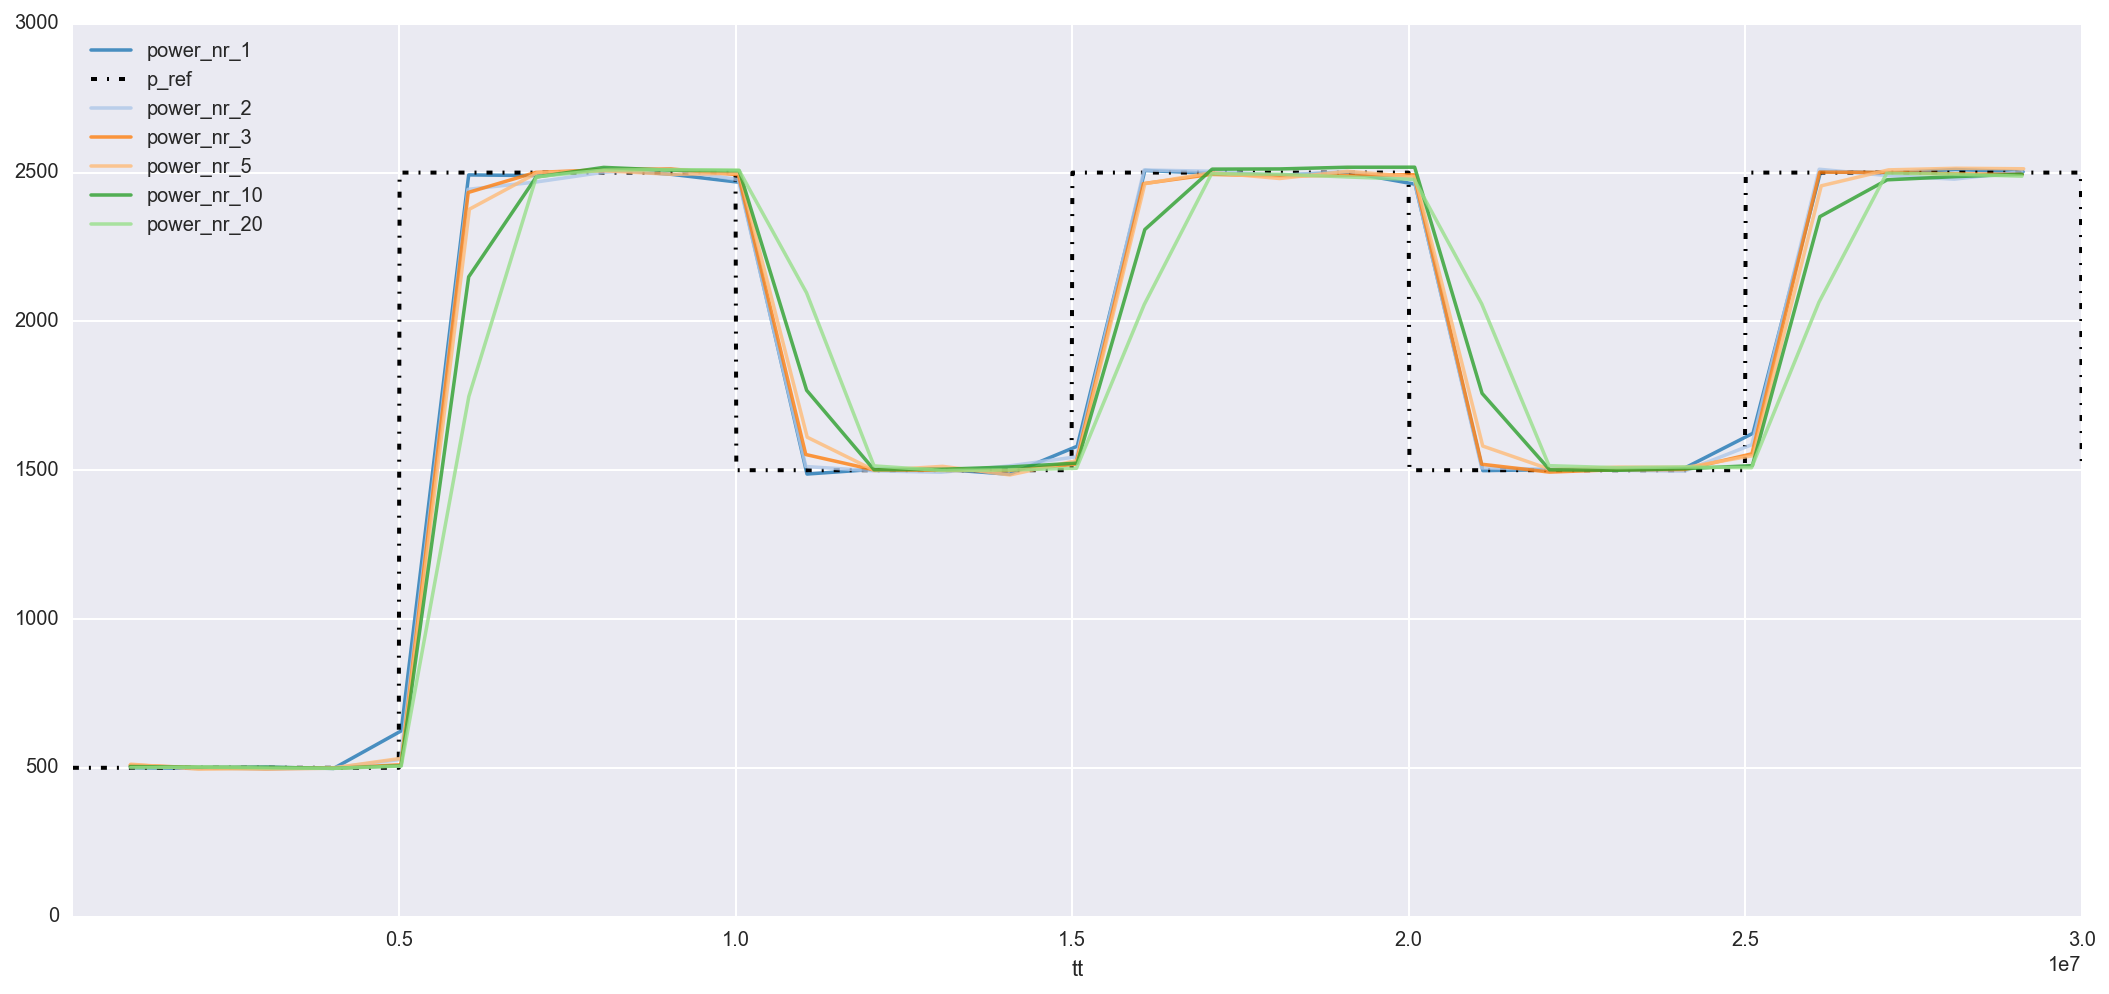

In [180]:
plt.subplots(1, 1, figsize=(18, 8))
ax = plt.gca()
for i, n_rep in enumerate([1, 2, 3, 5, 10, 20]):
    data, raw, buffer_rms = _enerpi_sampler_rms_auto(sampling_ms, delta_sampling=DELTA_SEC_DATA, 
                                t_simulacion_seg=30, n_rep_buffer=n_rep,
                                time_generator=_time_generator(sampling_ms, perfect_freq=False), 
                                func_power_rms=_func_power_multi_step)

    raw = pd.DataFrame(raw, columns=['tt', 'v']).set_index('tt')
    buffer_rms = pd.DataFrame(buffer_rms, columns=['tt', 'rms', 'p_ref']).set_index('tt')

    df = pd.DataFrame(data, columns=['power', 'ref', 'ts', 'p_ref', 'new'])
    df['tt'] = df['ts'] * 1e6
    ax = df[['tt', 'power']].set_index('tt')['power'].rename('power_nr_{}'.format(n_rep)
                                                            ).plot(ax=ax, alpha=.8, color=tableau20[i])
    if i == 0:
        buffer_rms['p_ref'].plot(ax=ax, color='k', lw=2, ls='-.')
plt.legend(loc='best')
plt.show()

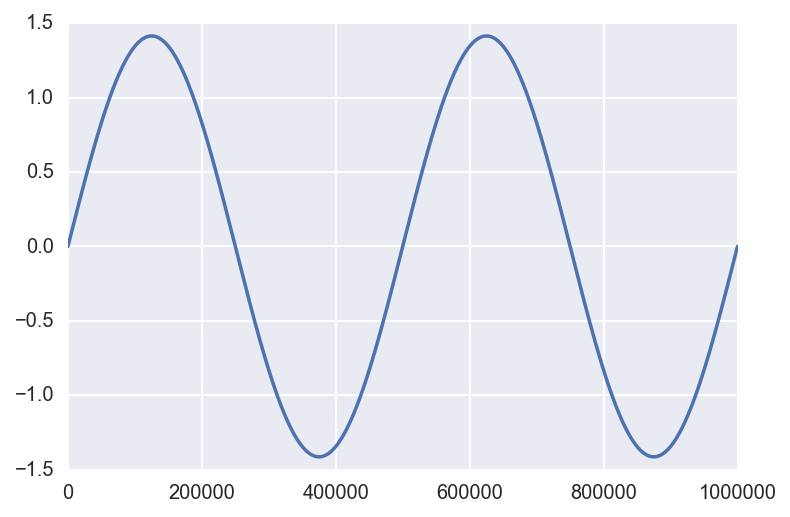

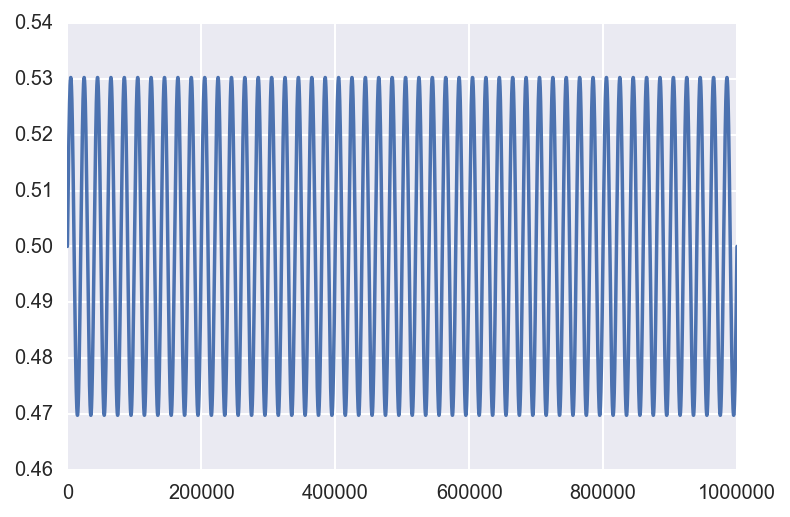

In [173]:
p_rms = 500
p_ac_sct = ((p_rms / V) / I_ref) * np.sqrt(2) * np.sin(2* np.pi * freq * tt / 1e6)
y = (V_ref / 2 + p_ac_sct) / V_ref

#y = (V_ref / 2 + ((p_rms / V) / I_ref) * np.sqrt(2) * np.sin(2* np.pi * freq * t_µs / 1e6)) / V_ref
#return round(y * niveles, 0) / niveles

tt = np.linspace(0, 1e6, 120e3)
plt.plot(tt, np.sqrt(2) * np.sin(2* np.pi * 2 * tt / 1e6))
plt.show()

plt.plot(tt, y)

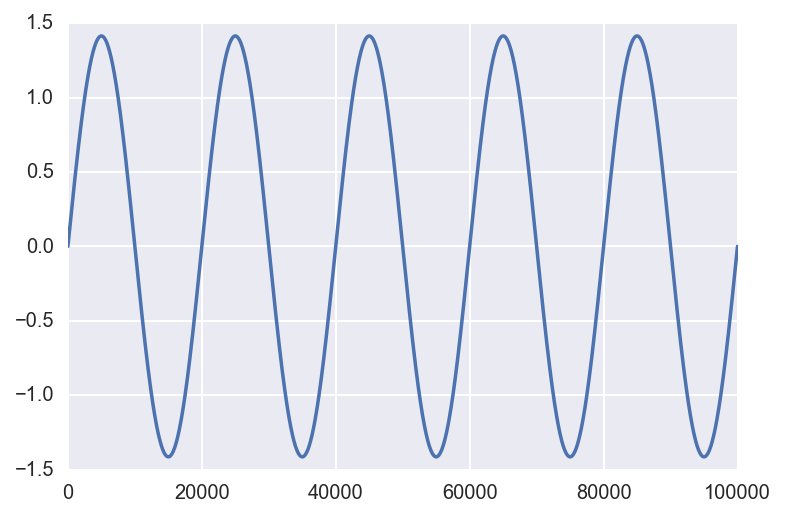

In [171]:
tt = np.linspace(0, 1e5, 120e3)
plt.plot(tt, np.sqrt(2) * np.sin(2* np.pi * freq * tt / 1e6))

In [48]:
roll_time = RMS_ROLL_WINDOW_SEC
s_calc = sampling_ms if sampling_ms > 0 else 8
n_samples = int(round(roll_time * 1000 / s_calc))
print_info('Sampling = {} ms; Roll time = {} s ==> Buffer N samples = {}'.format(sampling_ms, roll_time, n_samples))


def _rms_value(raw_samples, verbose=False):
    rms = np.sqrt(np.mean([(x - resta_bias)**2 for x in raw_samples])) * V * 30
    if verbose:
        print_red('RMS = {:.2f} (N={})'.format(rms, len(raw_samples)))
    return rms


def _get_sampling_values(num_samples):
    raw_values = [(y[random.randrange(0, T / step)]) for _ in range(num_samples)]
    return raw_values


def simu_sampling(num_samples, num_sims):
    samples = [_rms_value(_get_sampling_values(num_samples)) for _ in range(num_sims)]
    return samples
    
    
    
#{n: _get_sampling_value(n) for n in [30, 50, 60, 70, 84, 100, 500, 1000, 5000]};
simu_sampling(84, 4);

Sampling = 12 ms; Roll time = 2 s ==> Buffer N samples = 167


(array([ 1,  4,  8, 14, 14, 21, 23,  8,  3,  4]),
 array([ 494.70819974,  505.2945928 ,  515.88098585,  526.46737891,
         537.05377196,  547.64016502,  558.22655807,  568.81295112,
         579.39934418,  589.98573723,  600.57213029]))

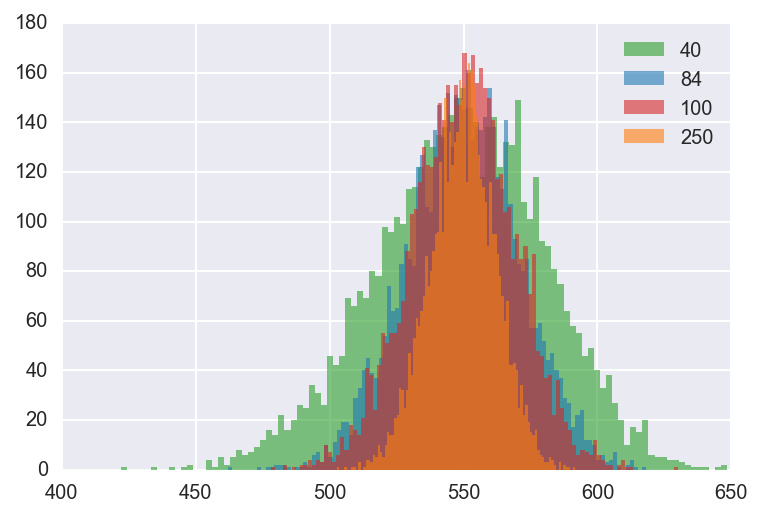

In [62]:
def plot_histogram_data(data, label='values', ind_color=0):
    hist, bins = np.histogram(data, bins=100)
    width = 1. * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    return plt.bar(center, hist, align='center', width=width, lw=0, color=tableau20[ind_color], alpha=.6, label=label)
    
    
plot_histogram_data(simu_sampling(40, 5000), label='40', ind_color=4)
plot_histogram_data(simu_sampling(84, 5000), label='84', ind_color=0)
plot_histogram_data(simu_sampling(100, 5000), label='100', ind_color=6)
plot_histogram_data(simu_sampling(250, 5000), label='250', ind_color=2)

#plot_histogram_data(simu_sampling(84, 10000), label='84', ind_color=0)
#plot_histogram_data(simu_sampling(40, 10000), label='84', ind_color=4)
#plot_histogram_data(simu_sampling(100, 10000), label='84', ind_color=6)
#plot_histogram_data(simu_sampling(250, 10000), label='84', ind_color=2)
plt.legend();
#plt.show()

In [12]:
y[random.randrange(0, T / step)]

0.41319260392890789

/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


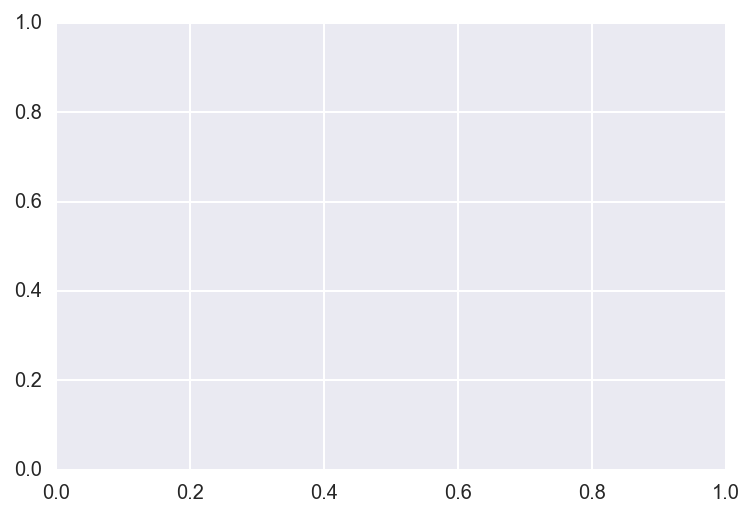